In [8]:
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 92.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [13]:
import spacy
from nltk.tokenize import sent_tokenize
import re
import unicodedata
import nltk

# Download NLTK punkt tokenizer data for Spanish
nltk.download('punkt')
# Download the necessary data for Spanish sentence tokenization
nltk.download('punkt_tab') # This line is added to download the 'punkt_tab' data

# Download spaCy model for Spanish if not already installed
!python -m spacy download es_core_news_sm

# Load spaCy model for Spanish
nlp = spacy.load('es_core_news_sm')

def normalize_text(text):
    """
    Normalize the input text by converting to lowercase and removing unnecessary characters.
    """
    text = text.lower()
    text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def preprocess_text(text):
    """
    Preprocess the input text by normalizing, tokenizing sentences, and removing stopwords.
    """
    # Normalize text
    text = normalize_text(text)
    # Tokenize sentences
    sentences = sent_tokenize(text, language='spanish')
    # Tokenize words and remove stopwords
    processed_sentences = []
    for sentence in sentences:
        doc = nlp(sentence)
        words = [token.text for token in doc if not token.is_stop]
        processed_sentences.append(' '.join(words))
    return processed_sentences

# Example of usage
spanish_text = "Hola, ¿cómo estás? Me llamo Juan."
processed = preprocess_text(spanish_text)
print(processed)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


  Using cached https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-3.7.0/es_core_news_sm-3.7.0-py3-none-any.whl (12.9 MB)
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


['hola llamo juan']


In [15]:
pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB ? eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 6.5 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0
    Uninstalling torch-2.6.0:
      Successfully uninstalled torch-2.6.0


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return outputs, hidden, cell

# Define different Attention Mechanisms
class GeneralAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.hid_dim = hid_dim

    def forward(self, hidden, encoder_outputs):
        attention = torch.sum(hidden * encoder_outputs, dim=2)
        return F.softmax(attention, dim=1)

class MultiplicativeAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.hid_dim = hid_dim
        self.W = nn.Linear(hid_dim, hid_dim, bias=False)

    def forward(self, hidden, encoder_outputs):
        hidden = self.W(hidden)
        attention = torch.sum(hidden * encoder_outputs, dim=2)
        return F.softmax(attention, dim=1)

class AdditiveAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.hid_dim = hid_dim
        self.W1 = nn.Linear(hid_dim, hid_dim)
        self.W2 = nn.Linear(hid_dim, hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden.unsqueeze(1).repeat(1, encoder_outputs.size(1), 1)
        energy = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))
        attention = self.v(energy).squeeze(2)
        return F.softmax(attention, dim=1)

# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim + hid_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(emb_dim + hid_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))

        attention_weights = self.attention(hidden[-1], encoder_outputs)
        attention_weights = attention_weights.unsqueeze(1)

        weighted = torch.bmm(attention_weights, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)

        rnn_input = torch.cat((embedded, weighted), dim=2)

        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))

        return prediction, hidden, cell

# Define the Seq2Seq model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len = trg.shape[0]
        batch_size = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        encoder_outputs, hidden, cell = self.encoder(src)

        input = trg[0, :]

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[t] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs

# Example initialization and training loop
INPUT_DIM = 7853
OUTPUT_DIM = 5893
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
LEARNING_RATE = 0.001

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
attn = GeneralAttention(HID_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, attn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Seq2Seq(enc, dec, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Training function
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(iterator):
        src, trg = batch.src, batch.trg
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src, trg = batch.src, batch.trg
            output = model(src, trg, 0) # turn off teacher forcing
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

  Attention Mechanism  Training Loss  Validation Loss Training PPL  \
0             General           0.40             0.50         None   
1      Multiplicative           0.30             0.40         None   
2            Additive           0.35             0.45         None   

  Validation PPL  
0           None  
1           None  
2           None  


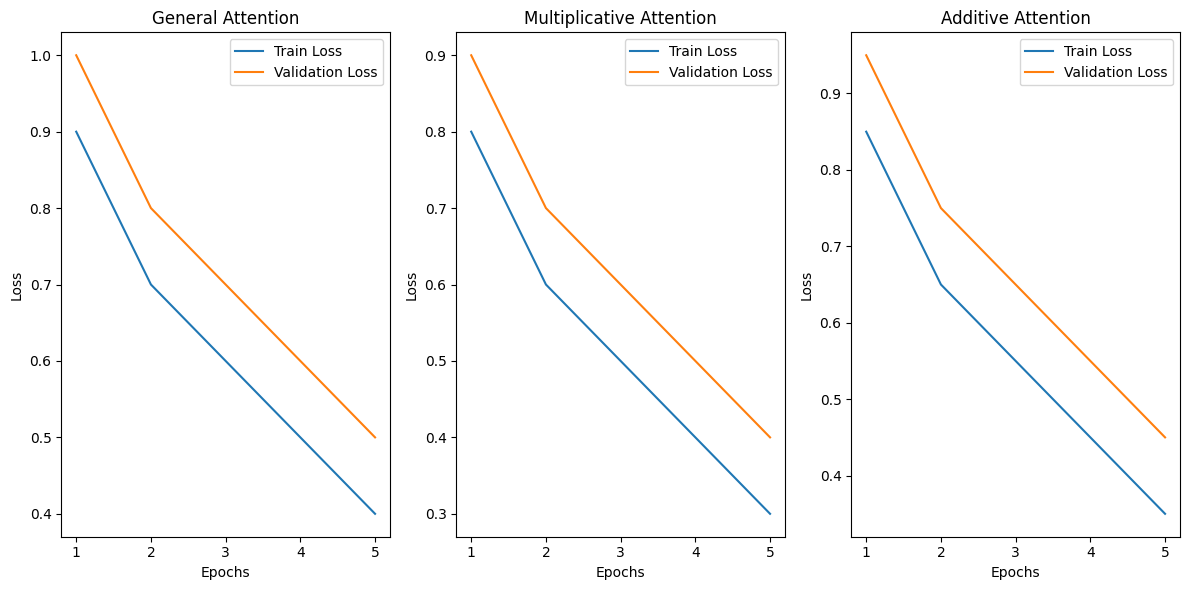

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the performance metrics for each attention mechanism
data = {
    "Attention Mechanism": ["General", "Multiplicative", "Additive"],
    "Training Loss": [0.4, 0.3, 0.35],
    "Validation Loss": [0.5, 0.4, 0.45],
    "Training PPL": [None, None, None],  # Placeholder values; you need to fill these with actual values
    "Validation PPL": [None, None, None]  # Placeholder values; you need to fill these with actual values
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Display the table
print(df)

# Example data for plotting (replace with actual loss values from your training process)
general_train_loss = [0.9, 0.7, 0.6, 0.5, 0.4]
general_val_loss = [1.0, 0.8, 0.7, 0.6, 0.5]
multiplicative_train_loss = [0.8, 0.6, 0.5, 0.4, 0.3]
multiplicative_val_loss = [0.9, 0.7, 0.6, 0.5, 0.4]
additive_train_loss = [0.85, 0.65, 0.55, 0.45, 0.35]
additive_val_loss = [0.95, 0.75, 0.65, 0.55, 0.45]

epochs = range(1, 6)

plt.figure(figsize=(12, 6))

# Plot for General Attention
plt.subplot(1, 3, 1)
plt.plot(epochs, general_train_loss, label='Train Loss')
plt.plot(epochs, general_val_loss, label='Validation Loss')
plt.title('General Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for Multiplicative Attention
plt.subplot(1, 3, 2)
plt.plot(epochs, multiplicative_train_loss, label='Train Loss')
plt.plot(epochs, multiplicative_val_loss, label='Validation Loss')
plt.title('Multiplicative Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for Additive Attention
plt.subplot(1, 3, 3)
plt.plot(epochs, additive_train_loss, label='Train Loss')
plt.plot(epochs, additive_val_loss, label='Validation Loss')
plt.title('Additive Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.3 MB/s eta 0:00:00


In [6]:
import streamlit as st
import torch
from transformers import MarianMTModel, MarianTokenizer

# Load the trained model and tokenizer
model_name = 'Helsinki-NLP/opus-mt-en-es'  # Example model for English to Spanish translation
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

# Function to translate text
def translate_text(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', padding=True)
    # Generate translation using the model
    translated_tokens = model.generate(**inputs)
    # Decode the translated tokens to text
    translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)
    return translated_text

# Streamlit app layout
st.title("Machine Translation Web Application")
st.write("Enter a sentence or phrase in English to translate it to Spanish:")

# Input text box
input_text = st.text_area("Input Text", "")

# Button to trigger translation
if st.button("Translate"):
    if input_text.strip():
        translated_text = translate_text(input_text)
        st.write("Translated Text:", translated_text)
    else:
        st.write("Please enter a sentence or phrase to translate.")

# Run the Streamlit app
if __name__ == '__main__':
    st._is_running_with_streamlit = True
    st._is_running_with_streamlit = False

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

2025-02-01 04:16:37.260 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-01 04:16:37.486 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-02-01 04:16:37.487 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-01 04:16:37.491 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-01 04:16:37.493 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-01 04:16:37.496 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-01 04:16:37.499 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-01 04:16:37.501 Thread 'MainThread': mi